In [1]:
import requests
import json
import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt

In [28]:
client = Socrata("data.cityofnewyork.us", "nw0pZM57EWuIKqCqQvWUFqAE0")
results = client.get("uvbq-3m68", limit = 500000, where="issue_date like'%/2018'")
client_df = pd.DataFrame.from_records(results)
client_df.head()

,amount_due,county,fine_amount,interest_amount,issue_date,issuing_agency,judgment_entry_date,license_type,payment_amount,penalty_amount,plate,precinct,reduction_amount,state,summons_image,summons_number,violation,violation_status,violation_time
0,0,NY,45,0,03/15/2018,TRAFFIC,NaN,PAS,45,0,XAYB44,024,0,NJ,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8634073543,PLTFRM LFTS LWRD POS COMM VEH,HEARING HELD-GUILTY,09:43A
1,0,NY,115,0,03/15/2018,TRAFFIC,NaN,PAS,125,10,GWL2947,024,0,NY,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8634073622,DOUBLE PARKING,NaN,10:23A
2,0,K,45,0,05/07/2018,TRAFFIC,NaN,PAS,75,30,GYG6579,077,0,NY,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8538575302,NO PARKING-STREET CLEANING,NaN,12:41P
3,0,BX,45,0,05/08/2018,TRAFFIC,NaN,PAS,45,0,GZH4470,049,0,NY,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8609796905,NO PARKING-STREET CLEANING,NaN,09:36A
4,45,K,35,0,07/28/2018,TRAFFIC,NaN,PAS,0,10,YWR0795,061,0,PA,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8673065628,FAIL TO DSPLY MUNI METER RECPT,NaN,11:16A


In [3]:
client_df["amount_due"] = pd.to_numeric(client_df["amount_due"])
client_df["fine_amount"] = pd.to_numeric(client_df["fine_amount"])
client_df["interest_amount"] = pd.to_numeric(client_df["interest_amount"])
client_df["payment_amount"] = pd.to_numeric(client_df["payment_amount"])
client_df["penalty_amount"] = pd.to_numeric(client_df["penalty_amount"])
client_df["reduction_amount"] = pd.to_numeric(client_df["reduction_amount"])

In [4]:
# Frequency of violations + Total fine amount by license plate

frequency_plate = client_df[["plate", "amount_due", 
                             "fine_amount", "interest_amount", 
                             "payment_amount", "penalty_amount",
                             "summons_number", "state"]]

frequency_plate_grouping = frequency_plate.groupby(["plate"])

In [5]:
meow = frequency_plate_grouping["summons_number"].count()
meow.head()

plate
0001DAD    1
0001FTD    1
0001VMD    1
00030CD    1
0003KED    3
Name: summons_number, dtype: int64

In [6]:
woof = frequency_plate_grouping["fine_amount"].sum()
woof.head()

plate
0001DAD    115
0001FTD    115
0001VMD     45
00030CD    115
0003KED    285
Name: fine_amount, dtype: int64

In [7]:
frequency = pd.DataFrame({"Total Violation Cost": woof, "Frequency": meow })
frequency_sorted = frequency.sort_values("Frequency", ascending=False)
frequency_sorted.head()

,Total Violation Cost,Frequency
plate,,
2028685,8155,85
12125MJ,8720,76
12359MG,8345,73
AP582Z,6355,67
0480PRA,6340,66


In [8]:
total_violation_cost_sorted = frequency.sort_values("Total Violation Cost", ascending=False)
total_violation_cost_sorted.head()

,Total Violation Cost,Frequency
plate,,
12125MJ,8720,76
12359MG,8345,73
2028685,8155,85
28054MC,7245,63
AP582Z,6355,67


In [27]:
bins = [0,2,250]
groups = ["Up to 2 Tickets", "More than 2 tickets"]

frequency_sorted["breakdown"] = pd.cut(frequency_sorted["Frequency"], bins, labels=groups)


In [10]:
breakdown_variable = frequency_sorted["breakdown"].value_counts()
breakdown_variable

Up to 2 Tickets        323752
More than 2 tickets     25233
Name: breakdown, dtype: int64

In [11]:
groupedby_breakdown = frequency_sorted.groupby(["breakdown"])
moo = groupedby_breakdown["Total Violation Cost"].sum()
moo

breakdown
Up to 2 Tickets        26002675
More than 2 tickets    10999925
Name: Total Violation Cost, dtype: int64

In [12]:
df_for_graph = pd.DataFrame({"Total $ Generated": moo})
df_for_graph.head()

,Total $ Generated
breakdown,
Up to 2 Tickets,26002675
More than 2 tickets,10999925


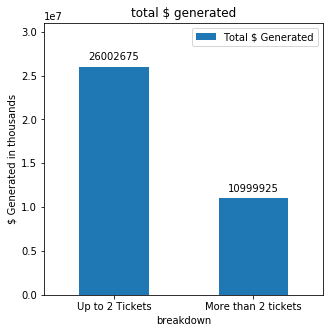

In [13]:
ax = df_for_graph.plot(kind="bar", figsize=(5,5), rot=0)
                  
plt.title("total $ generated")

plt.ylabel("$ Generated in thousands")

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.ylim(0, max(df_for_graph["Total $ Generated"])+ 5000000)

plt.show()

Text(0, 0.5, '')

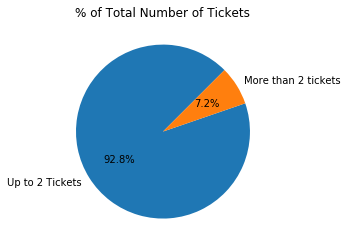

In [14]:
#pie chart

pie = breakdown_variable.plot(kind="pie", title="% of Total Number of Tickets", autopct="%1.1f%%", startangle=45)
pie.set_ylabel("")

Text(0, 0.5, '')

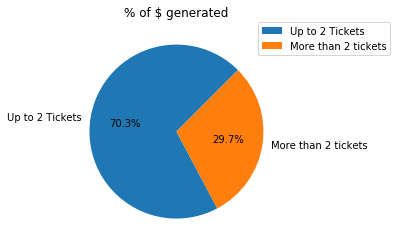

In [15]:
pie2 = moo.plot(kind="pie", title="% of $ generated", autopct="%1.1f%%", startangle=45)
plt.legend(loc="upper left", bbox_to_anchor=(0.85,1.025))
pie2.set_ylabel("")

In [16]:
# pies by state
#timeline of getting tickets
#top five flyers made $ vs 10,000 bottom others (do two buckets for visualization)


#Frequency of violations by state


# Total $ amount of violations by license plate
# Total $ amount of violations by state


In [17]:
# Frequency of violations + Total fine amount by State

In [26]:
state_df = client_df[["state", "amount_due", 
                             "fine_amount", "interest_amount", 
                             "payment_amount", "penalty_amount", "summons_number"]]

state_df["Label"] = np.where(state_df["state"]=="NY","NY","Out of State")


state_grouping = state_df.groupby(["Label"])


C:\Users\jesus.baquiax\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [19]:
fine_amount_sum = state_grouping["fine_amount"].sum()
fine_amount_sum.head()

Label
NY              28480825
Out of State     8521775
Name: fine_amount, dtype: int64

In [20]:
state_frequency = state_grouping["summons_number"].count()
state_frequency.head()

Label
NY              394358
Out of State    105642
Name: summons_number, dtype: int64

In [21]:
state_combined_df = pd.DataFrame({"Total Violation Cost": fine_amount_sum, "Frequency": state_frequency})

state_fine_sort = state_combined_df.sort_values("Total Violation Cost", ascending=False)
state_fine_sort.head()

,Total Violation Cost,Frequency
Label,,
NY,28480825,394358
Out of State,8521775,105642


In [22]:
state_frequency_sort = state_combined_df.sort_values("Frequency", ascending=False)
state_frequency_sort.head()

,Total Violation Cost,Frequency
Label,,
NY,28480825,394358
Out of State,8521775,105642


Text(0, 0.5, '')

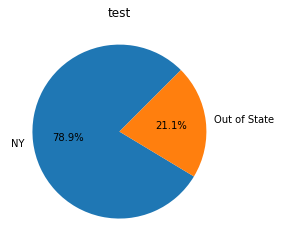

In [23]:
pie3 = state_frequency.plot(kind="pie", title="test", autopct="%1.1f%%", startangle=45)
pie3.set_ylabel("")

Text(0, 0.5, '')

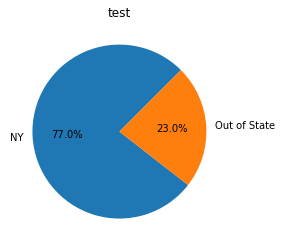

In [24]:
pie4 = fine_amount_sum.plot(kind="pie", title="test", autopct="%1.1f%%", startangle=45)
pie4.set_ylabel("")

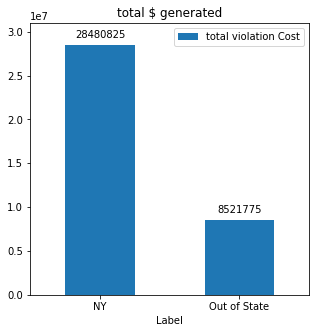

In [25]:
df_for_graph2 = pd.DataFrame({"total violation Cost": fine_amount_sum})

ay = df_for_graph2.plot(kind="bar", figsize=(5,5), rot=0)
                  
plt.title("total $ generated")

plt.ylabel("")

for p in ay.patches: 
    ay.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.ylim(0, max(df_for_graph["Total $ Generated"])+ 5000000)

plt.show()